### focus stacking w.r.t. distance from focus

In [1]:
import numpy as np
import subprocess
import glob
import skimage.io as imio
import re
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline

## camera behavior
def initialFocus(sid=2):
    #10.42.0.90: local 10.236.176.152: ip
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=2, pos=512):
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=2, pos=512):
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grab_image(sid=2, imres=8):
# I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images

    subprocess.run('rsh nvidia@10.236.176.152 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)

    # ok, now let's grab an image on the tegra
    subprocess.run('rsh nvidia@10.236.176.152 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('rcp nvidia@10.236.176.152:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    #pop=skimage.transform.rotate(pop,180)
    subprocess.run('mv dbGrab* photo_arch/', \
                   stdout=subprocess.PIPE, shell=True)
    return pop

In [2]:
# initialFocus()
curr = 700
setFocus(pos = curr)

b'sensor-id:2\nDemo Initialize\nDemo Start\nFocus Position:700\n'

In [3]:
img = grab_image()
gray_img = rgb2gray(img)

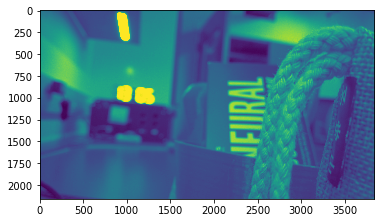

1.0


In [4]:
plt.imshow(gray_img)
plt.show()
print(gray_img.max())

In [5]:
from tensorflow.python.keras.models import load_model
dist_est_net = load_model('050-0.65.hdf5')
from quad_solver import solver
#     curr0 = curr + solver(curr, step)[0]
#     curr1 = curr + solver(curr, step)[1]

W1030 13:06:09.717433 140441827936000 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1030 13:06:09.718132 140441827936000 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/qian/Documents/autofocalstacking/quad_solver.py:11: RuntimeWarning: invalid value encountered in sqrt
  sol1 = (-b + np.sqrt(d1))/(2*a2)
/home/qian/Documents/autofocalstacking/quad_solver.py:13: RuntimeWarning: invalid value encountered in sqrt
  sol3 = (-b - np.sqrt(d1))/(2*a2)


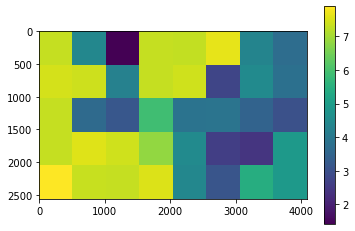

In [6]:
## blockwise estimate focus status
def reflect_pad(img, left, up):
    return np.pad(img, ((up, up), (left, left)), 'reflect')
    
def dist_est(gray_img, window_size = 512, step = 512):
    H, W = gray_img.shape
    if H % window_size != 0:
        up = (window_size - (H % window_size))//2
    if W % window_size != 0:
        left = (window_size - (W % window_size))//2
    gray_img = reflect_pad(gray_img, left, up)
    H, W = gray_img.shape
    dist_list = []
    dist_map = np.zeros(gray_img.shape)
    for i in range(0, H, step):
        for j in range(0, W, step):
            dist = dist_est_net.predict(gray_img[np.newaxis, i:i+window_size, j:j+window_size, np.newaxis])[0][0]
            dist_map[i:i+window_size, j:j+window_size] = dist
            curr0 = curr + solver(curr, dist)[0]
            curr1 = curr + solver(curr, dist)[1]
            if curr0 < 1023:
                dist_list.append(curr0)
            if curr1 > 425:
                dist_list.append(curr1)
    plt.imshow(dist_map)
    plt.colorbar()
    plt.show()
    return np.stack(dist_list)

dist_stack = dist_est(gray_img)

4 [966.51621018 507.33644499 867.78012957 573.74952236]


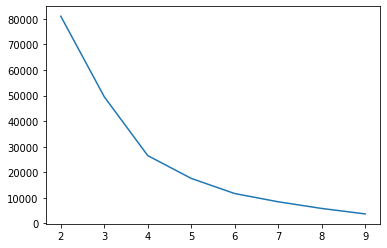

In [7]:
## grouping


def kmeans_cluster(dist_stack):
    from sklearn.cluster import KMeans
    import numpy as np
    kmeans_list = []
    for i in range(1, 10):
        kmeans = KMeans(n_clusters=i).fit(dist_stack.reshape(-1, 1))
#         print("categories: ", kmeans.labels_)
#         print("centers: ", kmeans.cluster_centers_)
        kmeans_list.append(kmeans.inertia_)
    kmeans_np = np.stack(kmeans_list)
    plt.plot(list(range(1, 10)), kmeans_np)
    diff = kmeans_np[1:] - kmeans_np[:-1]
    for k in range(diff.size-1):
        if 0.5 * diff[k] < diff[k+1]:
            break
    pos = k + 2
    kmeans = KMeans(n_clusters=pos).fit(dist_stack.reshape(-1, 1))
#         print("categories: ", kmeans.labels_)
    return pos, np.squeeze(kmeans.cluster_centers_)

pos, ccenters = kmeans_cluster(dist_stack)
print(pos, ccenters)

In [8]:
## follow grouping results: take pictures.
def grab_focus_stack(ccenters):
    imgs = []
    for focus_pos in ccenters:
        setFocus(pos = focus_pos)
        img = grab_image()
        imgs.append(img)
    imgs = np.stack(imgs)
    return imgs

stack = grab_focus_stack(ccenters)

(4, 2160, 3840, 3)


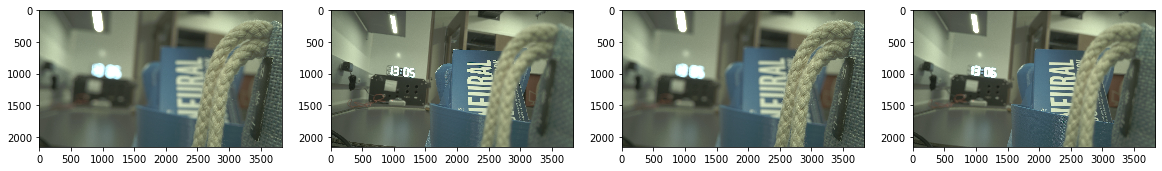

In [9]:
print(stack.shape)
fig, ax = plt.subplots(1, pos, figsize = (20, 16))
for p in range(pos):
    ax[p].imshow(stack[p])
plt.show()

In [10]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
import keras
import numpy as np

def encoder_block(x, _filters, _kernel_size, _strides, bn = True):
    y = layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(x)
    if bn is True:
        y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    y = layers.ReLU()(y)
    return y
def encoder_net(y):
    y = encoder_block(y, 32, (5, 5), (4, 4), bn = False)
    y = encoder_block(y, 128, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
    return y
def decoder_block(x, _filters, _kernel_size, _strides, dropout = False):
    y = layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size, 
                               strides=_strides, padding="same",
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    if dropout is True:
        y = layers.Dropout(0.5)(y)
    y = layers.ReLU()(y)
    return y
def decoder_net(y):
    y = decoder_block(y, 256, (5, 5), (4, 4))
    y = decoder_block(y, 256, (5, 5), (4, 4), False)
    y = decoder_block(y, 128, (5, 5), (4, 4), False)
    y = decoder_block(y, 32, (5, 5), (4, 4), False)
    y = encoder_block(y, 16, (5, 5), (1, 1), bn = False)
    y = layers.Conv2D(filters = 1, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
    return y
def fusionnet(inTensor1, inTensor2):
    out1 = encoder_net(inTensor1)
    out2 = encoder_net(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(x)
    return y
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
    y = K.tile(y, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, (1+y)/2])
    y2 = layers.Multiply()([inTensor2, 1-(1+y)/2])
    y = layers.Add()([y1, y2])
    return y
img1 = layers.Input(shape=(256, 256, 3))
img2 = layers.Input(shape=(256, 256, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])
FusionNet = Model(inputs = [img1, img2], outputs = [pred, intermed])
FusionNet.load_weights('/home/qian/Downloads/my_model_300e_5e-3_weights.h5')

Using TensorFlow backend.
W1030 13:06:54.033224 140441827936000 deprecation_wrapper.py:119] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1030 13:06:54.033761 140441827936000 deprecation_wrapper.py:119] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1030 13:06:54.036731 140441827936000 deprecation_wrapper.py:119] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1030 13:06:54.063148 140441827936000 deprecation_wrapper.py:119] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_d

In [11]:
## multifocus fusion
def padding(img, left, up):
    
    return np.pad(img, ((up, up), (left, left), (0, 0)), 'constant')

def crop(img, left, up):
    if left >0 and up > 0:
        return img[up:-up, left:-left]
    if left == 0 and up == 0:
        return img
    if left > 0 and up ==0:
        return img[:, left:-left]
    if up > 0 and left == 0:
        return img[up:-up]

def fuse_img(start_img, next_img):
    H, W, C = start_img.shape
    left = 0
    up = 0
    if H % 256 != 0:
        up = (256 - (H % 256))//2
    if W % 256 != 0:
        left = (256 - (W % 256))//2
    start_img = padding(start_img, left, up)
    next_img = padding(next_img, left, up)
    H, W, C = start_img.shape
    
    fused_img = np.zeros(start_img.shape)
    start_img = start_img[np.newaxis, ...] *2 -1
    next_img = next_img[np.newaxis, ...] *2 -1

    for i in range(0, H, 256):
        for j in range(0, W, 256):
            fused_img[i:i+256, j:j+256, :] = FusionNet.predict(
                [start_img[:, i:i+256, j:j+256, :], next_img[:, i:i+256, j:j+256, :]])[0]
    
    fused_img = crop(fused_img, left, up)/2+0.5
    return fused_img
    

def multifocus_fusion(imgs):
    start_img = imgs[0]
#     imgs_fused = []
#     imgs_fused.append(start_img)
    
    for i in range(1, imgs.shape[0]):
        next_img = imgs[i]
        img_fused = fuse_img(start_img, next_img)
#         imgs_fused.append(img_fused)
        start_img = img_fused

    return img_fused

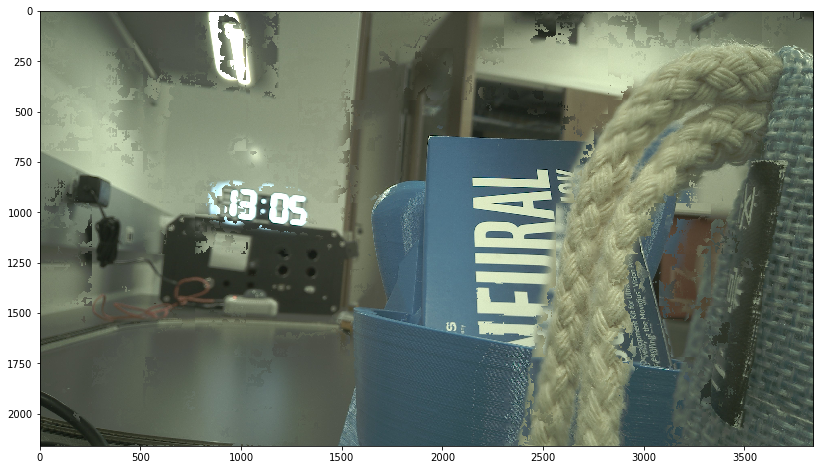

In [12]:
img = multifocus_fusion(stack/255.)
fig = plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.show()